<a href="https://colab.research.google.com/github/thomasdevasia/deep-image-prior/blob/master/SAR_Despeckling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/thomasdevasia/deep-image-prior
# !mv deep-image-prior/* ./
%cd deep-image-prior

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 412 (delta 58), reused 94 (delta 44), pack-reused 289
Receiving objects: 100% (412/412), 126.42 MiB | 50.12 MiB/s, done.
Resolving deltas: 100% (213/213), done.
/content/deep-image-prior


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *

import scipy.io as sio

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1

# plotting image inside closure
PLOT = True

sigma = 25
sigma_ = sigma/255.

In [ ]:
# png SAR image
fnamep = 'data/denoising/SAR3.png'
# .mat SAR images
# fname = 'data/denoising/CL7.mat'
fname = 'data/denoising/CL8.mat'
# fname = 'data/denoising/CL9.mat'

# Load and prepare Image

In [ ]:
# reading mat files
test = sio.loadmat(fname)
intImage = test['x2']
temp = pil_to_np(intImage)
img_pil = np_to_pil(temp)
img_pil = crop_image(img_pil, d=32)
img_np = 255*pil_to_np(img_pil)

# normalizing image
val_min = img_np.min()
val_range = img_np.max() - val_min
img_np = (img_np - val_min) / val_range 

# img_np = pil_to_np(img_pil)
# img_np

In [ ]:
img_np.shape

(1, 672, 672)

In [ ]:
# img_pil

In [ ]:
# img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
# img_noisy_np = pil_to_np(img_noisy_pil)

# img_pil = img_noisy_pil
# img_np = img_noisy_np

# plot_image_grid([img_np], 4, 5);

In [ ]:
# im = crop_image(get_image(fname, imsize)[0], d=128)
# im.size

In [ ]:
# # reading png files
# # img_pil = get_image(fname, imsize)[0]
# img_pil = crop_image(get_image(fnamep, imsize)[0], d=32)
# # converting to numpy
# img_np = pil_to_np(img_pil)
# # img_np

In [ ]:
# # # adding speckle noise
# def get_noisy_img(img_np, sigma):
#   """Adds noise to an image.
    
#   Args: 
#       img_np: image, np.array with values from 0 to 1
#       sigma: std of the noise
#   """

#   np.random.seed(42)

#   noise = np.random.normal(loc=1, scale=sigma_, size=img_np.shape)

#   # multiplicative noise for speckle noise
#   # imgNoise = img_np + (img_np * noise)
#   imgNoise = np.log(img_np * noise)

#   img_noisy_np = np.clip(abs(imgNoise), 0, 1).astype(np.float32)
    
#   img_noisy_pil = np_to_pil(img_noisy_np)

#   return img_noisy_pil, img_noisy_np

In [ ]:
# correct way
# from sklearn import preprocessing
def generateAddSpeckle(img_np, L):

    '''

    Creates multiplicative speckled image with number of looks L. L increases lower noise effect, L is lower noise is strong. 

    '''

    sum_ = 0

    for i in range(L):

        seq1 = np.random.randn(img_np.shape[1], img_np.shape[2])

        seq2 = np.random.randn(img_np.shape[1], img_np.shape[2])

        temp = np.multiply(seq1, seq1) + np.multiply(seq2, seq2)

        sum_ = sum_ + temp/2

        #print(i)

    speckle_ = np.multiply(sum_,1/L)

    img_noisy_np = np.multiply(img_np, speckle_)
    img_noisy_np = np.clip(img_noisy_np, 0, 1).astype(np.float32)
    img_noisy_np = np.log(img_noisy_np)
    img_noisy_np[img_noisy_np==-np.inf] = 0

    # img_noisy_np = np.log(img_noisy_np)
    
    # norm = np.linalg.norm(img_noisy_np)
    # img_noisy_np = np.log(img_noisy_np/norm)

    # val_min = img_noisy_np.min()
    # val_range = img_noisy_np.max() - val_min
    # img_noisy_np = (img_noisy_np - val_min) / val_range
    # img_noisy_np = np.log(img_noisy_np)
    # img_noisy_np[img_noisy_np==-np.inf] = 0

    

    return img_noisy_np

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html /content/SAR_Despeckling.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[NbConvertApp] Converting notebook /content/SAR_Despeckling.ipynb to html
[NbConvertApp] Writing 9827415 bytes to /content/SAR_Despeckling.html


In [ ]:
# def get_log(img_noisy_np):
#   img_noisy_np = np.log(img_noisy_np)
#   img_noisy_np[img_noisy_np==-np.inf] = 0
#   return img_noisy_np

In [ ]:
# with ground truth available
# img_noisy_pil, img_noisy_np = get_noisy_img(img_np, sigma_)
img_noisy_np = generateAddSpeckle(img_np, 20)
# img_noisy_np = get_log(img_noisy_np)
# img_noisy_np = np.exp(img_noisy_np)
print(f'PSNR value: {compare_psnr(img_noisy_np, img_np, data_range=img_noisy_np.max()-img_noisy_np.min())}')
img_noisy_pil = np_to_pil(img_noisy_np)
plot_image_grid([img_np],4,6)
plot_image_grid([img_noisy_np],4,6)
(img_np.shape, img_noisy_np.shape)
# img_noisy_np

In [ ]:
# back = np.exp(img_noisy_np)
# val_min = img_noisy_np.min()
# val_range = img_noisy_np.max() - val_min
# img_noisy_np = (back - val_min) / val_range
# plot_image_grid([back],4,6)
# ()
# img_noisy_np[img_noisy_np==-np.inf]
# img_noisy_np.min()

In [ ]:
# np.where(img_noisy_np == 0)
# np.where(np.log(img_noisy_np), )

# Define model

In [ ]:
INPUT = 'noise' # 'meshgrid'

pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
# 0.0001 0.001 0.01 0.1
LR = 0.01

# adam LBFGS 
OPTIMIZER='adam'
# OPTIMIZER='LBFGS'

show_every = 100
exp_weight=0.99

In [ ]:
# 3000 4000 6000 10000 15000
num_iter = 1000
# 16 32 48 64
input_depth = 32
figsize = 4 

In [ ]:
# returns a model

# unet
# net = get_net(input_depth, 'UNet', pad,
#               skip_n33d=128, 
#               skip_n33u=128, 
#               skip_n11=4, 
#               num_scales=5,
#               n_channels=1,
#               upsample_mode='bilinear').type(dtype)

# resnet
# net = ResNet(input_depth, 1, 10, 16, need_sigmoid=True, act_fun='LeakyReLU')
# net = net.type(dtype)

# texture_nets
# net = get_net(input_depth, 'texture_nets', pad,
#               skip_n33d=128, 
#               skip_n33u=128, 
#               skip_n11=4, 
#               num_scales=5,
#               n_channels=1,
#               upsample_mode='bilinear').type(dtype)

# net = get_texture_nets(inp=1, conv_num=input_depth, ratios=[32, 16, 8, 4, 2, 1], 
#                        fill_noise=False, pad=pad).type(dtype)
# --------------------------------------
# skip
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              n_channels=1,
              upsample_mode='bilinear',
              act_fun='LeakyReLU').type(dtype)

inside skip


In [ ]:
# ./utils/common_utils.py
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]), noise_type='n').type(dtype).detach()
net_input.shape

torch.Size([1, 32, 672, 672])

In [ ]:
type(net)

torch.nn.modules.container.Sequential

In [ ]:
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

Number of params: 2217573


In [ ]:
# Loss
mse = torch.nn.MSELoss().type(dtype)
# noisy img to torch
# img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# norm = np.linalg.norm(img_noisy_np)
# img_noisy_np_norm = img_noisy_np/norm
# img_noisy_np = np.log(img_noisy_np)
# plot_image_grid([img_noisy_np],4,6)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

In [ ]:
# img_noisy_torch = torch.log(img_noisy_torch)

# Optimize Model

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0

In [ ]:
# if reg_noise_std > 0:
#         net_input = net_input_saved + (noise.normal_() * reg_noise_std)
# out = net(net_input)
# #  out_np = torch_to_np(out)
# out = torch.exp(out)
# out_np = torch_to_np(out)
# plot_image_grid([out_np],0,1)
# total_loss = mse(out, img_noisy_torch)
# total_loss.backward()

In [ ]:
# Loss funftion printing image
lossVal = []
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        # print(noise.normal_())
    net_input = np_to_torch(generateAddSpeckle(torch_to_np(net_input_saved), 20)).type(dtype)
    
    out = net(net_input)
    # out1 = (out.exp() - out.exp().min()) / (out.exp().max()-out.exp().min())
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    # print(out.shape, img_noisy_torch.shape)
    total_loss = mse(out, img_noisy_torch.exp())
    total_loss.backward()
        
    # print(img_noisy_np.shape, out.detach().cpu().numpy()[0].shape)
    # out_npi = out.detach().cpu().numpy()[0], data_range=img_noisy_np.max()-img_noisy_np.min()
    # print(test.shape)
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0], data_range=img_noisy_np.max()-img_noisy_np.min()) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # So 'PSRN_gt', 'PSNR_gt_sm' only when ground truth is provided
    print('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), end='')

    lossVal.append(total_loss.item())
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # print(out_np)
        plot_image_grid([out_np, 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        # print('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f\n' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), end='')         
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

In [ ]:
p = get_params(OPT_OVER, net, net_input)

In [ ]:
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))

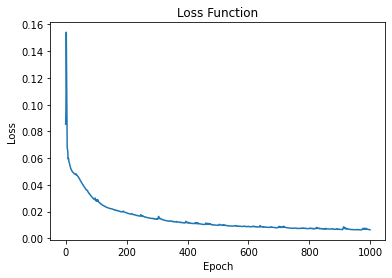

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(lossVal)),lossVal)
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
exp = np.exp(out_np)
val_min = exp.min()
val_range = exp.max() - val_min
exp = (exp - val_min) / val_range 
exp = (exp - val_min) / val_range 

q = plot_image_grid([img_np], factor=13)
q = plot_image_grid([exp], factor=13)

In [1]:
compare_psnr(img_noisy_np, out_np, data_range=img_noisy_np.max()-img_noisy_np.min())

NameError: ignored

In [ ]:
# compare_psnr(img_np, exp, data_range=exp.max()-exp.min()) 
# compare_psnr(img_np, out_np) 

In [ ]:
q = plot_image_grid([exp, img_np], factor=13)

In [ ]:
# # function for l 1 to 20

# L_value = []

# before_psnr_noise = []

# final_psnr_noise = []
# final_psnr_gt = []

# for i in range(10,21):
#   L_value.append(i)
#   print(f'\nCurrent L value {i}')

#   img_noisy_pil, img_noisy_np = generateAddSpeckle(img_np, i)
#   plot_image_grid([img_np, img_noisy_np],4,6)
  
#   before_psnr_noise.append(compare_psnr(img_np,img_noisy_np))

#   net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]), noise_type='n').type(dtype).detach()

#   mse = torch.nn.MSELoss().type(dtype)
#   img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

#   net_input_saved = net_input.detach().clone()
#   noise = net_input.detach().clone()
#   out_avg = None
#   last_net = None
#   psrn_noisy_last = 0
#   i = 0

#   p = get_params(OPT_OVER, net, net_input)

#   optimize(OPTIMIZER, p, closure, LR, num_iter)

#   out_np = torch_to_np(net(net_input))

#   final_psnr_noise.append(compare_psnr(img_noisy_np, out_np)) 

#   final_psnr_gt.append(compare_psnr(img_np, out_np))


In [ ]:
# import pandas as pd

# table = pd.DataFrame({
#     'L_value':L_value,
#     'before_psnr_noise':before_psnr_noise,
#     'final_psnr_noise':final_psnr_noise,
#     'final_psnr_gt':final_psnr_gt
# }).set_index('L_value')

# table
# # final_psnr_gt.append(0)
# # final_psnr_noise.append(0)

#----------------------

In [ ]:
(img_pil.size[1], img_pil.size[0])

(672, 672)

In [ ]:
zero  = torch.zeros([1 ,32 ,544 ,896])
var=1./10

In [ ]:
res = zero.normal_()*var
res<0

In [ ]:
img_noisy_np.shape

In [ ]:
torch.zeros([4,2,3])

In [ ]:
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, [2,5,8])

In [ ]:
# np_to_torch(s).shape
torch.from_numpy(s).shape